# LIBRARIES TO BE USED

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

# Load the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# DATA PROCESSING

In [2]:
# Load the data
full_data = pd.read_csv('C:/Users/Asus/Downloads/SWAGAT_INPUT_income_dataset_balanced.csv')

In [3]:
full_data.columns

Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

In [4]:
# Drop unnecessary columns
full_data.drop('Id', axis=1, inplace=True)

In [5]:
full_data.columns

Index(['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

# ONE HOT ENCODING

In [6]:
# Define columns to one-hot encode
cols_to_encode = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE', 'CITY','Profession']


In [7]:
# Perform one-hot encoding
def one_hot_encode(data):
    unique_categories = list(set(data))
    encoded_data = []
    for value in data:
        encoding = [0] * len(unique_categories)
        category_index = unique_categories.index(value)
        encoding[category_index] = 1
        encoded_data.append(encoding)
    return encoded_data, unique_categories

In [8]:
extra = pd.DataFrame()
for col in cols_to_encode:
    full_data[col] = full_data[col].str.replace('_', ' ')
    data = full_data[col]
    encoded_data, unique_categories = one_hot_encode(data)
    df = pd.DataFrame(encoded_data, columns=unique_categories)
    df = df.astype(int)
    extra = pd.concat([extra, df], axis=1)

In [9]:
#Drop the columns that were one-hot encoded
full_data.drop(cols_to_encode, axis=1, inplace=True)

# DATA NORMALIZING

In [20]:
def normalize_feature(feature):
    min_val = np.min(feature)
    max_val = np.max(feature)
    range_val = max_val - min_val
    return (feature - min_val) / range_val

# Perform feature scaling
scaled_data = full_data.drop('Risk_Flag', axis=1).apply(normalize_feature, axis=0)

# Assign scaled data back to full_data
for col in scaled_data.columns:
    full_data[col] = scaled_data[col]

# RESTOREING THE MATRIX

In [21]:
extra.columns

Index(['single', 'married', 'owned', 'rented', 'norent noown', 'yes', 'no',
       'Uttarakhand', 'Delhi', 'Uttar Pradesh',
       ...
       'Industrial Engineer', 'Graphic Designer', 'Geologist', 'Aviator',
       'Librarian', 'Air traffic controller', 'Technical writer', 'Engineer',
       'Physician', 'Petroleum Engineer'],
      dtype='object', length=404)

In [22]:
# Reset index to make it unique
full_data.reset_index(drop=True, inplace=True)
extra.reset_index(drop=True, inplace=True)

# Concatenate encoded columns
full_data = pd.concat([full_data, extra], axis=1)

In [23]:
full_data.head

<bound method NDFrame.head of          Income       Age  Experience  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  \
0      0.012743  0.534483        0.50         0.500000               0.00   
1      0.003648  0.206897        0.65         0.714286               0.25   
2      0.061536  0.448276        0.55         0.428571               0.25   
3      0.022383  0.741379        0.05         0.071429               0.00   
4      0.097070  0.689655        0.70         0.500000               0.25   
...         ...       ...         ...              ...                ...   
34899  0.976933  0.775862        0.05         0.071429               0.75   
34900  0.956995  0.517241        0.65         0.857143               0.75   
34901  0.915559  0.241379        0.60         0.857143               0.50   
34902  0.973952  0.241379        0.85         0.928571               0.50   
34903  0.912239  0.637931        0.60         0.642857               1.00   

       Risk_Flag  single  married  owned  ren

In [24]:
element_count = np.count_nonzero(full_data['Risk_Flag'] == 1)
element_count

17452

DATA IS ALREADY BALANCED 

In [25]:
# Sample balanced dataset
full_data_balanced = full_data.copy()

# Split as train and test

In [26]:
# Split features and target
X, y = full_data_balanced.drop('Risk_Flag', axis=1), full_data_balanced['Risk_Flag']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [27]:
X_train.shape

(27923, 409)

# LOGISTIC REGRESION WITH L2 REGULARIZATION

In [28]:
# Logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Loss function
def log_loss(y, y_pred):
    return - (y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

# Cost function with L2 regularization
def cost_func_vec_regularized(y, y_pred, w, lambda_reg):
    loss_vec = np.array([log_loss(y[i], y_pred[i]) for i in range(len(y))])
    regularization_term = (lambda_reg / (2 * len(y))) * np.sum(w**2)
    cost = np.dot(loss_vec, np.ones(len(y))) / len(y) + regularization_term
    return cost

# Gradient calculation with L2 regularization
def grad_logreg_vec_regularized(X, y, w, b, lambda_reg): 
    y_pred = logistic(np.matmul(X, w) + b * np.ones(len(X)))
    grad_w = (np.matmul(y_pred - y, X) + lambda_reg * w) / len(X)
    grad_b = np.dot(y_pred - y, np.ones(len(X))) / len(X)
    return grad_w, grad_b

# Gradient descent with L2 regularization
def grad_desc_regularized(X, y, w, b, alpha, n_iter, lambda_reg, show_cost=True, show_params=False): 
    cost_history = []
    for i in range(n_iter):
        grad_w, grad_b = grad_logreg_vec_regularized(X, y, w, b, lambda_reg)   
        w -= alpha * grad_w
        b -= alpha * grad_b
        y_pred = logistic(np.matmul(X, w) + b * np.ones(len(X)))
        cost = cost_func_vec_regularized(y, y_pred, w, lambda_reg)
        cost_history.append(cost)
        if show_cost and (i % (n_iter // 100) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.5f}")
    return w, b, cost_history


# TAKING RESULTS FOR THE CODE

In [29]:
# Initialize weights and bias
n_features = X_train.shape[1]
w_init = np.full(n_features, 0.0)
b_init = 0

In [30]:
# Set hyperparameters
alpha = 0.5
n_iter = 100
lambda_reg = 1 # Regularization parameter

In [31]:
# Train the model
w_final, b_final, cost_history = grad_desc_regularized(X_train.to_numpy(), y_train.to_numpy(), w_init, b_init, alpha, n_iter, lambda_reg)

Iteration      0:    Cost  0.69161
Iteration      1:    Cost  0.69015
Iteration      2:    Cost  0.68874
Iteration      3:    Cost  0.68735
Iteration      4:    Cost  0.68600
Iteration      5:    Cost  0.68467
Iteration      6:    Cost  0.68336
Iteration      7:    Cost  0.68209
Iteration      8:    Cost  0.68084
Iteration      9:    Cost  0.67961
Iteration     10:    Cost  0.67841
Iteration     11:    Cost  0.67723
Iteration     12:    Cost  0.67608
Iteration     13:    Cost  0.67494
Iteration     14:    Cost  0.67383
Iteration     15:    Cost  0.67275
Iteration     16:    Cost  0.67168
Iteration     17:    Cost  0.67063
Iteration     18:    Cost  0.66961
Iteration     19:    Cost  0.66860
Iteration     20:    Cost  0.66761
Iteration     21:    Cost  0.66665
Iteration     22:    Cost  0.66570
Iteration     23:    Cost  0.66477
Iteration     24:    Cost  0.66385
Iteration     25:    Cost  0.66296
Iteration     26:    Cost  0.66208
Iteration     27:    Cost  0.66122
Iteration     28:   

# EVALUATION OF THE RESULT

In [32]:
# Make predictions
def predict(X, w, b):
    return logistic(np.matmul(X, w) + b * np.ones(len(X)))


In [33]:
def calculate_precision_recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

def calculate_f1_score(y_true, y_pred):
    precision, recall = calculate_precision_recall(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1_score

# Calculate F1 score for train and test sets
train_f1_score = calculate_f1_score(y_train.to_numpy(), (predict(X_train.to_numpy(), w_final, b_final) >= 0.5).astype(int))
test_f1_score = calculate_f1_score(y_test.to_numpy(), (predict(X_test.to_numpy(), w_final, b_final) >= 0.5).astype(int))

print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

Training F1 Score: 0.6958
Test F1 Score: 0.6994


# EVALUATION OF RESULT FOR DIFFERENT VALUES OF ALPHA

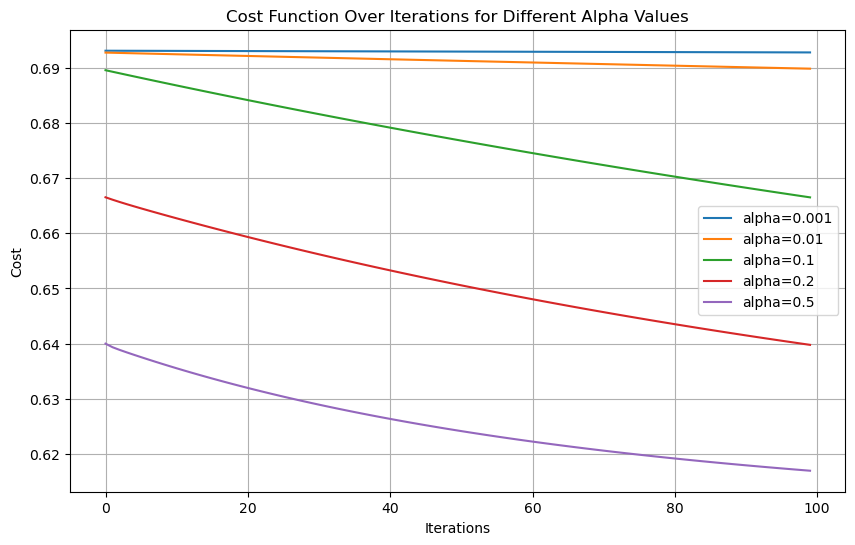

F1 Scores for Different Alpha Values:
Alpha	Training F1 Score	Test F1 Score
0.001	0.0114		0.0135
0.01	0.3569		0.3654
0.1	0.6799		0.6794
0.2	0.6913		0.6939
0.5	0.6973		0.7039


In [34]:
# Define a range of alpha values to test
alphas = [0.001, 0.01, 0.1, 0.2, 0.5]

# Initialize weights and bias
w_init = np.full(n_features, 0.0)
b_init = 0

# Set other hyperparameters
n_iter = 100
lambda_reg = 0.0005

# Initialize dictionaries to store F1 scores and cost histories
f1_scores = {}
cost_histories = {}

# Train the model for each alpha value and record the cost history and F1 score
for alpha in alphas:
    # Train the model
    w_final, b_final, cost_history = grad_desc_regularized(X_train.to_numpy(), y_train.to_numpy(), w_init, b_init, alpha, n_iter, lambda_reg, show_cost=False)
    
    # Calculate F1 score for training set
    train_f1_score = calculate_f1_score(y_train.to_numpy(), (predict(X_train.to_numpy(), w_final, b_final) >= 0.5).astype(int))
    
    # Calculate F1 score for test set
    test_f1_score = calculate_f1_score(y_test.to_numpy(), (predict(X_test.to_numpy(), w_final, b_final) >= 0.5).astype(int))
    
    # Store F1 scores and cost histories
    f1_scores[alpha] = (train_f1_score, test_f1_score)
    cost_histories[alpha] = cost_history

# Plot the cost function over iterations for each alpha value
plt.figure(figsize=(10, 6))
for alpha, cost_history in cost_histories.items():
    plt.plot(range(n_iter), cost_history, label=f'alpha={alpha}')
plt.title('Cost Function Over Iterations for Different Alpha Values')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

# Output F1 scores for each alpha value
print("F1 Scores for Different Alpha Values:")
print("Alpha\tTraining F1 Score\tTest F1 Score")
for alpha, (train_f1_score, test_f1_score) in f1_scores.items():
    print(f"{alpha}\t{train_f1_score:.4f}\t\t{test_f1_score:.4f}")


# EVALUATION OF RESULT FOR DIFFERENT VALUES OF lambda

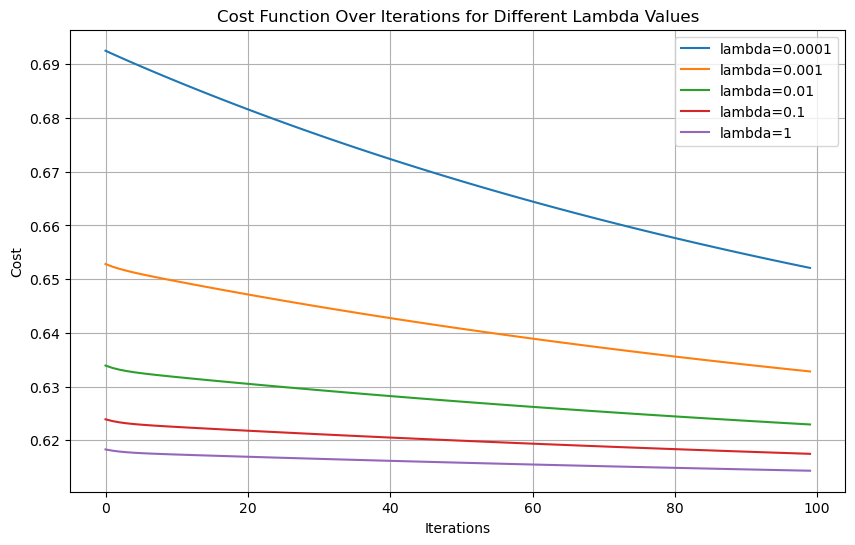

F1 Scores for Different Lambda Values:
Lambda	Training F1 Score	Test F1 Score
0.0001	0.6886		0.6905
0.001	0.6937		0.6969
0.01	0.6961		0.7024
0.1	0.6973		0.7040
1	0.6973		0.7044


In [35]:
# Define a range of lambda values to test
lambdas = [0.0001, 0.001, 0.01, 0.1, 1]

# Initialize weights and bias
w_init = np.full(n_features, 0.0)
b_init = 0

# Set other hyperparameters
alpha = 0.2
n_iter = 100

# Initialize dictionaries to store F1 scores and cost histories
f1_scores_lambda = {}
cost_histories_lambda = {}

# Train the model for each lambda value and record the cost history and F1 score
for lambda_reg in lambdas:
    # Train the model
    w_final, b_final, cost_history = grad_desc_regularized(X_train.to_numpy(), y_train.to_numpy(), w_init, b_init, alpha, n_iter, lambda_reg, show_cost=False)
    
    # Calculate F1 score for training set
    train_f1_score = calculate_f1_score(y_train.to_numpy(), (predict(X_train.to_numpy(), w_final, b_final) >= 0.5).astype(int))
    
    # Calculate F1 score for test set
    test_f1_score = calculate_f1_score(y_test.to_numpy(), (predict(X_test.to_numpy(), w_final, b_final) >= 0.5).astype(int))
    
    # Store F1 scores and cost histories
    f1_scores_lambda[lambda_reg] = (train_f1_score, test_f1_score)
    cost_histories_lambda[lambda_reg] = cost_history

# Plot the cost function over iterations for each lambda value
plt.figure(figsize=(10, 6))
for lambda_reg, cost_history in cost_histories_lambda.items():
    plt.plot(range(n_iter), cost_history, label=f'lambda={lambda_reg}')
plt.title('Cost Function Over Iterations for Different Lambda Values')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

# Output F1 scores for each lambda value
print("F1 Scores for Different Lambda Values:")
print("Lambda\tTraining F1 Score\tTest F1 Score")
for lambda_reg, (train_f1_score, test_f1_score) in f1_scores_lambda.items():
    print(f"{lambda_reg}\t{train_f1_score:.4f}\t\t{test_f1_score:.4f}")


## BEST RESULT

Training F1 Score: 0.7015 Test F1 Score: 0.7074

alpha = 0.5 n_iter = 1000 lambda_reg = 0.1